In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.models.tf_ising import TFIChain
from tenpy.tools.params import get_parameter


from tenpy.algorithms import dmrg

# statistics
from scipy.optimize import curve_fit
from scipy import stats

__all__ = ['KitaevLadder', 'Ising1D']

In [2]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        nNNa = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
        nNNb = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
        kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)
        
        Lattice.__init__(self, [L], sites, **kwargs)
        

class Ising1D(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', 'parity', self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)
        g = get_parameter(model_params, 'g', 1., self.name, True)
        
        # onsite terms
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-g, u, 'Sigmaz')

        # coupling terms
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
#             self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
#             self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors_a']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
    pass

        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors_a'], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


[None, None, None, None]


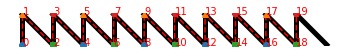

In [3]:
plot_lattice()

In [4]:
def run(calc_correlation=True):

    model_params = dict(Jz=1., g=1., L=1, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = Ising1D(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 100
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 10000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [5]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()

In [6]:
data = run()

parameter 'verbose'=1 for Ising1D
parameter 'L'=1 for Ising1D
parameter 'Jz'=1.0 for Ising1D
parameter 'g'=1.0 for Ising1D


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=10000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 0.0001, 'decay': 1.2, 'disable_after': 100} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732297456008759, S = nan, norm_err = 1.9e-03
Current memory usage 133.5 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8102e-10, max_E_trunc = 2.2087e-09
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732370590834989, 

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732389661186403, S = 0.7621356269385068, norm_err = 1.6e-05
Current memory usage 133.7 MB, time elapsed: 30.1 s
Delta E = 4.6612e-12, Delta S = 2.7171e-05 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1042e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732389660694139, S = 0.7623400791883979, norm_err = 1.2e-05
Current memory usage 133.7 MB, time elapsed: 31.1 s
Delta E = 4.9226e-12, Delta S = 2.0445e-05 (per sweep)
max_trunc_err = 3.3854e-08, max_E_trunc = 2.1085e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732389660230865, S = 0.7624935914275580, norm_err = 1.0e-05
Current memory usage 133.7 MB, time elapsed: 32.1 s
Delta E = 4.6327e-12, Delta S = 1.5351e-05 (per sweep)
max_trunc_err = 3.3908e-08, max_E_trunc = 2.1119e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 230, ag

Updating environment
.....
sweep 60, age = 804
Energy = -1.2732393353886948, S = nan, norm_err = 1.1e-04
Current memory usage 135.3 MB, time elapsed: 11.8 s
Delta E = -5.7323e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7926e-08, max_E_trunc = 6.0848e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 70, age = 924
Energy = -1.2732393387757384, S = nan, norm_err = 1.1e-04
Current memory usage 135.3 MB, time elapsed: 13.5 s
Delta E = -3.3870e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8501e-08, max_E_trunc = 6.2793e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 80, age = 1044
Energy = -1.2732393409625331, S = nan, norm_err = 7.2e-05
Current memory usage 135.3 MB, time elapsed: 15.1 s
Delta E = -2.1868e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9124e-08, max_E_trunc = 6.4858e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 90, age = 1164
Energy = -1.2732393423944472, S = nan, 

Updating environment
.....
sweep 270, age = 3324
Energy = -1.2732393451096868, S = 0.8015600452991630, norm_err = 3.9e-06
Current memory usage 135.3 MB, time elapsed: 36.3 s
Delta E = 7.8444e-13, Delta S = 2.1255e-05 (per sweep)
max_trunc_err = 1.1346e-08, max_E_trunc = 7.6560e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 280, age = 3444
Energy = -1.2732393451084363, S = 0.8015446173601861, norm_err = 4.8e-06
Current memory usage 135.3 MB, time elapsed: 37.3 s
Delta E = 1.2506e-13, Delta S = -1.5428e-06 (per sweep)
max_trunc_err = 1.1350e-08, max_E_trunc = 7.6587e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 290, age = 3564
Energy = -1.2732393451045709, S = 0.8016249619042151, norm_err = 4.0e-06
Current memory usage 135.3 MB, time elapsed: 38.3 s
Delta E = 3.8654e-13, Delta S = 8.0345e-06 (per sweep)
max_trunc_err = 1.1364e-08, max_E_trunc = 7.6674e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 300, a

Updating environment
.....
sweep 480, age = 5844
Energy = -1.2732393450811514, S = 0.8018940422309347, norm_err = 6.1e-06
Current memory usage 136.1 MB, time elapsed: 57.3 s
Delta E = 7.1623e-13, Delta S = -2.6385e-06 (per sweep)
max_trunc_err = 1.1406e-08, max_E_trunc = 7.6948e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 490, age = 5964
Energy = -1.2732393450727386, S = 0.8019178316332570, norm_err = 7.8e-06
Current memory usage 136.1 MB, time elapsed: 58.3 s
Delta E = 8.4128e-13, Delta S = 2.3789e-06 (per sweep)
max_trunc_err = 1.1409e-08, max_E_trunc = 7.6968e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 500, age = 6084
Energy = -1.2732393450573909, S = 0.8019174092776566, norm_err = 9.8e-06
Current memory usage 136.1 MB, time elapsed: 59.4 s
Delta E = 1.5348e-12, Delta S = -4.2236e-08 (per sweep)
max_trunc_err = 1.1408e-08, max_E_trunc = 7.6964e-08
MPS bond dimensions: [22, 22, 22, 22]
DMRG finished after 500 sweeps.
total 

Updating environment
.....
sweep 160, age = 2004
Energy = -1.2732394985441147, S = 0.8733167169976396, norm_err = 1.7e-05
Current memory usage 136.1 MB, time elapsed: 40.5 s
Delta E = -2.2892e-10, Delta S = 1.3779e-04 (per sweep)
max_trunc_err = 2.9880e-09, max_E_trunc = 1.9875e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 170, age = 2124
Energy = -1.2732394997877918, S = 0.8737834167617565, norm_err = 7.1e-05
Current memory usage 136.1 MB, time elapsed: 41.7 s
Delta E = -1.2437e-10, Delta S = 4.6670e-05 (per sweep)
max_trunc_err = 2.8165e-09, max_E_trunc = 1.8737e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 180, age = 2244
Energy = -1.2732395004287014, S = 0.8706150306641420, norm_err = 7.8e-05
Current memory usage 136.1 MB, time elapsed: 43.0 s
Delta E = -6.4091e-11, Delta S = -3.1684e-04 (per sweep)
max_trunc_err = 2.6586e-09, max_E_trunc = 1.7730e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 190

Updating environment
.....
sweep 370, age = 4524
Energy = -1.2732395021672573, S = 0.8707429747035877, norm_err = 4.4e-05
Current memory usage 136.5 MB, time elapsed: 67.3 s
Delta E = -3.1241e-11, Delta S = 4.5570e-05 (per sweep)
max_trunc_err = 2.3241e-09, max_E_trunc = 1.5508e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 380, age = 4644
Energy = -1.2732395021043885, S = 0.8716882084552942, norm_err = 6.0e-05
Current memory usage 136.5 MB, time elapsed: 68.4 s
Delta E = 6.2869e-12, Delta S = 9.4523e-05 (per sweep)
max_trunc_err = 2.3204e-09, max_E_trunc = 1.5491e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 390, age = 4764
Energy = -1.2732395019983187, S = 0.8703809121433786, norm_err = 8.1e-05
Current memory usage 136.5 MB, time elapsed: 69.5 s
Delta E = 1.0607e-11, Delta S = -1.3073e-04 (per sweep)
max_trunc_err = 2.3244e-09, max_E_trunc = 1.5512e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 400, 

Updating environment
.....
sweep 580, age = 7044
Energy = -1.2732395018088027, S = 0.8698059411020833, norm_err = 1.0e-04
Current memory usage 136.7 MB, time elapsed: 91.2 s
Delta E = 2.2919e-11, Delta S = -1.8067e-04 (per sweep)
max_trunc_err = 2.3154e-09, max_E_trunc = 1.5456e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 590, age = 7164
Energy = -1.2732395021735101, S = 0.8702269277769736, norm_err = 3.0e-05
Current memory usage 137.0 MB, time elapsed: 92.5 s
Delta E = -3.6471e-11, Delta S = 4.2099e-05 (per sweep)
max_trunc_err = 2.3113e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 600, age = 7284
Energy = -1.2732395020211698, S = 0.8716066265955563, norm_err = 6.5e-05
Current memory usage 137.0 MB, time elapsed: 93.6 s
Delta E = 1.5234e-11, Delta S = 1.3797e-04 (per sweep)
max_trunc_err = 2.3136e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 610, 

Updating environment
.....
sweep 790, age = 9564
Energy = -1.2732395021723732, S = 0.8702626200990327, norm_err = 3.7e-05
Current memory usage 138.3 MB, time elapsed: 114.6 s
Delta E = -3.4311e-11, Delta S = 4.6368e-05 (per sweep)
max_trunc_err = 2.3104e-09, max_E_trunc = 1.5427e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 800, age = 9684
Energy = -1.2732395020832428, S = 0.8713986855728357, norm_err = 6.2e-05
Current memory usage 138.5 MB, time elapsed: 115.6 s
Delta E = 8.9130e-12, Delta S = 1.1361e-04 (per sweep)
max_trunc_err = 2.3105e-09, max_E_trunc = 1.5434e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 810, age = 9804
Energy = -1.2732395019286287, S = 0.8698996305533838, norm_err = 8.9e-05
Current memory usage 138.5 MB, time elapsed: 116.6 s
Delta E = 1.5461e-11, Delta S = -1.4991e-04 (per sweep)
max_trunc_err = 2.3138e-09, max_E_trunc = 1.5441e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 82

Updating environment
.....
sweep 1000, age = 12084
Energy = -1.2732395019006617, S = 0.8715699107266702, norm_err = 9.9e-05
Current memory usage 139.3 MB, time elapsed: 137.6 s
Delta E = 1.4484e-11, Delta S = 1.4577e-04 (per sweep)
max_trunc_err = 2.3076e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1010, age = 12204
Energy = -1.2732395017487761, S = 0.8718830421629872, norm_err = 9.6e-05
Current memory usage 139.6 MB, time elapsed: 138.9 s
Delta E = 1.5189e-11, Delta S = 3.1313e-05 (per sweep)
max_trunc_err = 2.3285e-09, max_E_trunc = 1.5541e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1020, age = 12324
Energy = -1.2732395020113927, S = 0.8717639617403488, norm_err = 4.0e-05
Current memory usage 139.6 MB, time elapsed: 140.1 s
Delta E = -2.6262e-11, Delta S = -1.1908e-05 (per sweep)
max_trunc_err = 2.3411e-09, max_E_trunc = 1.5591e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sw

Updating environment
.....
sweep 1210, age = 14604
Energy = -1.2732395019202158, S = 0.8698916770320174, norm_err = 9.1e-05
Current memory usage 140.5 MB, time elapsed: 161.0 s
Delta E = 1.4825e-11, Delta S = -1.4879e-04 (per sweep)
max_trunc_err = 2.3151e-09, max_E_trunc = 1.5458e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1220, age = 14724
Energy = -1.2732395021880620, S = 0.8703167444307338, norm_err = 3.6e-05
Current memory usage 140.8 MB, time elapsed: 162.2 s
Delta E = -2.6785e-11, Delta S = 4.2507e-05 (per sweep)
max_trunc_err = 2.3109e-09, max_E_trunc = 1.5440e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1230, age = 14844
Energy = -1.2732395021171214, S = 0.8713112856923293, norm_err = 5.8e-05
Current memory usage 140.8 MB, time elapsed: 163.3 s
Delta E = 7.0941e-12, Delta S = 9.9454e-05 (per sweep)
max_trunc_err = 2.3110e-09, max_E_trunc = 1.5436e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sw

Updating environment
.....
sweep 1420, age = 17124
Energy = -1.2732395021403136, S = 0.8712059723427981, norm_err = 5.7e-05
Current memory usage 141.8 MB, time elapsed: 184.4 s
Delta E = 4.4565e-12, Delta S = 8.4945e-05 (per sweep)
max_trunc_err = 2.3088e-09, max_E_trunc = 1.5450e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1430, age = 17244
Energy = -1.2732395020561853, S = 0.8700892638182408, norm_err = 7.2e-05
Current memory usage 142.1 MB, time elapsed: 185.4 s
Delta E = 8.4128e-12, Delta S = -1.1167e-04 (per sweep)
max_trunc_err = 2.3137e-09, max_E_trunc = 1.5461e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1440, age = 17364
Energy = -1.2732395019093019, S = 0.8715796337744509, norm_err = 9.7e-05
Current memory usage 142.1 MB, time elapsed: 186.6 s
Delta E = 1.4688e-11, Delta S = 1.4904e-04 (per sweep)
max_trunc_err = 2.3087e-09, max_E_trunc = 1.5436e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
swe

Updating environment
.....
sweep 1630, age = 19644
Energy = -1.2732395021980665, S = 0.8712315737330953, norm_err = 2.5e-05
Current memory usage 143.8 MB, time elapsed: 208.0 s
Delta E = -2.0736e-11, Delta S = -4.0027e-05 (per sweep)
max_trunc_err = 2.3162e-09, max_E_trunc = 1.5491e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1640, age = 19764
Energy = -1.2732395020907461, S = 0.8700638089452830, norm_err = 5.6e-05
Current memory usage 143.8 MB, time elapsed: 209.1 s
Delta E = 1.0732e-11, Delta S = -1.1678e-04 (per sweep)
max_trunc_err = 2.3105e-09, max_E_trunc = 1.5443e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1650, age = 19884
Energy = -1.2732395019247633, S = 0.8715993690627341, norm_err = 9.0e-05
Current memory usage 143.8 MB, time elapsed: 210.1 s
Delta E = 1.6598e-11, Delta S = 1.5356e-04 (per sweep)
max_trunc_err = 2.3096e-09, max_E_trunc = 1.5432e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 1840, age = 22164
Energy = -1.2732395012917550, S = 0.8724804068324520, norm_err = 1.2e-04
Current memory usage 144.7 MB, time elapsed: 231.4 s
Delta E = 7.2623e-11, Delta S = 9.0329e-05 (per sweep)
max_trunc_err = 2.3256e-09, max_E_trunc = 1.5520e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1850, age = 22284
Energy = -1.2732395021239427, S = 0.8710187101716836, norm_err = 8.3e-05
Current memory usage 144.7 MB, time elapsed: 232.5 s
Delta E = -8.3219e-11, Delta S = -1.4617e-04 (per sweep)
max_trunc_err = 2.3094e-09, max_E_trunc = 1.5421e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1860, age = 22404
Energy = -1.2732395021289449, S = 0.8703519003159124, norm_err = 7.5e-05
Current memory usage 144.7 MB, time elapsed: 233.5 s
Delta E = -5.0022e-13, Delta S = -6.6681e-05 (per sweep)
max_trunc_err = 2.3192e-09, max_E_trunc = 1.5480e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....


Updating environment
.....
sweep 2050, age = 24684
Energy = -1.2732395018783791, S = 0.8716169161152880, norm_err = 1.0e-04
Current memory usage 145.5 MB, time elapsed: 254.9 s
Delta E = 1.6553e-11, Delta S = 1.5513e-04 (per sweep)
max_trunc_err = 2.3090e-09, max_E_trunc = 1.5436e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2060, age = 24804
Energy = -1.2732395021907905, S = 0.8711402200507558, norm_err = 3.9e-05
Current memory usage 145.8 MB, time elapsed: 256.1 s
Delta E = -3.1241e-11, Delta S = -4.7670e-05 (per sweep)
max_trunc_err = 2.3106e-09, max_E_trunc = 1.5440e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2070, age = 24924
Energy = -1.2732395021262164, S = 0.8701614966263288, norm_err = 5.6e-05
Current memory usage 145.8 MB, time elapsed: 257.2 s
Delta E = 6.4574e-12, Delta S = -9.7872e-05 (per sweep)
max_trunc_err = 2.3122e-09, max_E_trunc = 1.5450e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 2260, age = 27204
Energy = -1.2732394823824507, S = 0.8650500767318731, norm_err = 6.7e-04
Current memory usage 146.8 MB, time elapsed: 279.5 s
Delta E = 1.9546e-09, Delta S = -4.8927e-04 (per sweep)
max_trunc_err = 2.3484e-09, max_E_trunc = 1.5636e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2270, age = 27324
Energy = -1.2732395021384946, S = 0.8705941786573259, norm_err = 3.8e-05
Current memory usage 146.8 MB, time elapsed: 280.9 s
Delta E = -1.9756e-09, Delta S = 5.5441e-04 (per sweep)
max_trunc_err = 2.3026e-09, max_E_trunc = 1.5374e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2280, age = 27444
Energy = -1.2732395022185301, S = 0.8707669940348322, norm_err = 2.3e-05
Current memory usage 146.8 MB, time elapsed: 282.0 s
Delta E = -8.0036e-12, Delta S = 1.7282e-05 (per sweep)
max_trunc_err = 2.3192e-09, max_E_trunc = 1.5491e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 2470, age = 29724
Energy = -1.2732395021794218, S = 0.8703394302248777, norm_err = 4.5e-05
Current memory usage 148.2 MB, time elapsed: 303.3 s
Delta E = -2.8285e-11, Delta S = 4.8427e-05 (per sweep)
max_trunc_err = 2.3121e-09, max_E_trunc = 1.5454e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2480, age = 29844
Energy = -1.2732395021266711, S = 0.8712505935936121, norm_err = 6.0e-05
Current memory usage 148.2 MB, time elapsed: 304.4 s
Delta E = 5.2751e-12, Delta S = 9.1116e-05 (per sweep)
max_trunc_err = 2.3091e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2490, age = 29964
Energy = -1.2732395020202603, S = 0.8700484982483460, norm_err = 7.7e-05
Current memory usage 148.2 MB, time elapsed: 305.4 s
Delta E = 1.0641e-11, Delta S = -1.2021e-04 (per sweep)
max_trunc_err = 2.3137e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sw

Updating environment
.....
sweep 2680, age = 32244
Energy = -1.2732395020002514, S = 0.8714665689254129, norm_err = 8.2e-05
Current memory usage 150.0 MB, time elapsed: 326.3 s
Delta E = 1.1369e-11, Delta S = 1.3063e-04 (per sweep)
max_trunc_err = 2.3085e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2690, age = 32364
Energy = -1.2732395018110765, S = 0.8697514034838616, norm_err = 1.1e-04
Current memory usage 150.0 MB, time elapsed: 327.3 s
Delta E = 1.8917e-11, Delta S = -1.7152e-04 (per sweep)
max_trunc_err = 2.3145e-09, max_E_trunc = 1.5469e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2700, age = 32484
Energy = -1.2732395021685079, S = 0.8702605618446089, norm_err = 4.4e-05
Current memory usage 150.0 MB, time elapsed: 328.5 s
Delta E = -3.5743e-11, Delta S = 5.0916e-05 (per sweep)
max_trunc_err = 2.3109e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sw

Updating environment
.....
sweep 2890, age = 34764
Energy = -1.2732395019238538, S = 0.8716100024310593, norm_err = 9.1e-05
Current memory usage 150.8 MB, time elapsed: 349.1 s
Delta E = 1.6735e-11, Delta S = 1.5542e-04 (per sweep)
max_trunc_err = 2.3096e-09, max_E_trunc = 1.5418e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2900, age = 34884
Energy = -1.2732395021830598, S = 0.8711422297866104, norm_err = 4.0e-05
Current memory usage 150.8 MB, time elapsed: 350.3 s
Delta E = -2.5921e-11, Delta S = -4.6777e-05 (per sweep)
max_trunc_err = 2.3101e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2910, age = 35004
Energy = -1.2732395021203047, S = 0.8701558937971432, norm_err = 5.7e-05
Current memory usage 150.8 MB, time elapsed: 351.3 s
Delta E = 6.2755e-12, Delta S = -9.8634e-05 (per sweep)
max_trunc_err = 2.3117e-09, max_E_trunc = 1.5440e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 3100, age = 37284
Energy = -1.2732395021230332, S = 0.8703544008654185, norm_err = 7.5e-05
Current memory usage 151.6 MB, time elapsed: 371.9 s
Delta E = -5.4570e-13, Delta S = -6.6048e-05 (per sweep)
max_trunc_err = 2.3193e-09, max_E_trunc = 1.5527e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 3110, age = 37404
Energy = -1.2732395020721015, S = 0.8712368263467021, norm_err = 7.6e-05
Current memory usage 151.9 MB, time elapsed: 373.0 s
Delta E = 5.0932e-12, Delta S = 8.8243e-05 (per sweep)
max_trunc_err = 2.3069e-09, max_E_trunc = 1.5410e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 3120, age = 37524
Energy = -1.2732395020084368, S = 0.8700517688685855, norm_err = 8.3e-05
Current memory usage 151.9 MB, time elapsed: 374.0 s
Delta E = 6.3665e-12, Delta S = -1.1851e-04 (per sweep)
max_trunc_err = 2.3156e-09, max_E_trunc = 1.5505e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.27e-05
Call psi.canonical_form()
DMRG finished after 3260 sweeps.
total size = 39404, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32, 32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999999+0j)
After the canonicalization:
Bond dim =  [32, 32, 32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  45 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732382668847535, S = nan, norm_err = 1.3e-03
Current memory usage 152.9 MB, time elapsed: 4.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0477e-11, max_E_trunc = 9.2257e-11
MPS bond dimensions: [45, 

Updating environment
.....
sweep 190, age = 2364
Energy = -1.2732395197028268, S = 0.8501385843513957, norm_err = 8.4e-05
Current memory usage 152.9 MB, time elapsed: 44.0 s
Delta E = -1.8872e-10, Delta S = 3.3115e-04 (per sweep)
max_trunc_err = 2.1747e-10, max_E_trunc = 1.3461e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732395213095060, S = 0.8539551500026520, norm_err = 1.3e-04
Current memory usage 152.9 MB, time elapsed: 45.2 s
Delta E = -1.6067e-10, Delta S = 3.8166e-04 (per sweep)
max_trunc_err = 2.3199e-10, max_E_trunc = 1.4352e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732395227278630, S = 0.8570590870798276, norm_err = 1.1e-04
Current memory usage 152.9 MB, time elapsed: 46.5 s
Delta E = -1.4184e-10, Delta S = 3.1039e-04 (per sweep)
max_trunc_err = 2.4669e-10, max_E_trunc = 1.5243e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -1.2732395317226519, S = 0.8945117915044325, norm_err = 4.2e-05
Current memory usage 152.9 MB, time elapsed: 68.0 s
Delta E = -1.2255e-11, Delta S = 1.2617e-04 (per sweep)
max_trunc_err = 4.6059e-10, max_E_trunc = 2.8158e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 410, age = 5004
Energy = -1.2732395318154204, S = 0.8956835384793140, norm_err = 4.3e-05
Current memory usage 152.9 MB, time elapsed: 69.0 s
Delta E = -9.2768e-12, Delta S = 1.1717e-04 (per sweep)
max_trunc_err = 4.6825e-10, max_E_trunc = 2.8622e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 420, age = 5124
Energy = -1.2732395319652596, S = 0.8967037485139828, norm_err = 3.4e-05
Current memory usage 152.9 MB, time elapsed: 70.2 s
Delta E = -1.4984e-11, Delta S = 1.0202e-04 (per sweep)
max_trunc_err = 4.7435e-10, max_E_trunc = 2.9067e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -1.2732395328705479, S = 0.9108763473050637, norm_err = 2.5e-05
Current memory usage 152.9 MB, time elapsed: 92.7 s
Delta E = -3.1832e-13, Delta S = 6.3409e-05 (per sweep)
max_trunc_err = 5.7542e-10, max_E_trunc = 3.5106e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 620, age = 7524
Energy = -1.2732395328566781, S = 0.9112783296245371, norm_err = 2.7e-05
Current memory usage 152.9 MB, time elapsed: 93.7 s
Delta E = 1.3870e-12, Delta S = 4.0198e-05 (per sweep)
max_trunc_err = 5.7862e-10, max_E_trunc = 3.5325e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 630, age = 7644
Energy = -1.2732395329194333, S = 0.9119264683011846, norm_err = 2.2e-05
Current memory usage 152.9 MB, time elapsed: 95.0 s
Delta E = -6.2755e-12, Delta S = 6.4814e-05 (per sweep)
max_trunc_err = 5.8520e-10, max_E_trunc = 3.5707e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 640, 

Updating environment
.....
sweep 820, age = 9924
Energy = -1.2732395330472173, S = 0.9176666647662781, norm_err = 1.1e-05
Current memory usage 152.9 MB, time elapsed: 117.7 s
Delta E = 7.2760e-13, Delta S = 5.9469e-05 (per sweep)
max_trunc_err = 6.2748e-10, max_E_trunc = 3.8308e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 830, age = 10044
Energy = -1.2732395330426698, S = 0.9174087460707598, norm_err = 8.1e-06
Current memory usage 152.9 MB, time elapsed: 118.8 s
Delta E = 4.5475e-13, Delta S = -2.5792e-05 (per sweep)
max_trunc_err = 6.2596e-10, max_E_trunc = 3.8126e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 840, age = 10164
Energy = -1.2732395330397139, S = 0.9178577405342738, norm_err = 1.2e-05
Current memory usage 152.9 MB, time elapsed: 120.0 s
Delta E = 2.9559e-13, Delta S = 4.4899e-05 (per sweep)
max_trunc_err = 6.3156e-10, max_E_trunc = 3.8526e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 8

Updating environment
.....
sweep 1030, age = 12444
Energy = -1.2732395330726831, S = 0.9200493828450491, norm_err = 6.4e-06
Current memory usage 152.9 MB, time elapsed: 143.7 s
Delta E = -6.4801e-12, Delta S = -1.8721e-05 (per sweep)
max_trunc_err = 6.4801e-10, max_E_trunc = 3.9381e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 1040, age = 12564
Energy = -1.2732395330772306, S = 0.9201301136505127, norm_err = 1.9e-05
Current memory usage 152.9 MB, time elapsed: 144.9 s
Delta E = -4.5475e-13, Delta S = 8.0731e-06 (per sweep)
max_trunc_err = 6.4814e-10, max_E_trunc = 3.9436e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 1050, age = 12684
Energy = -1.2732395330694999, S = 0.9203080671572836, norm_err = 1.6e-05
Current memory usage 152.9 MB, time elapsed: 146.0 s
Delta E = 7.7307e-13, Delta S = 1.7795e-05 (per sweep)
max_trunc_err = 6.4960e-10, max_E_trunc = 3.9618e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -1.2732395330194777, S = 0.9211730977207399, norm_err = 5.2e-05
Current memory usage 152.9 MB, time elapsed: 169.0 s
Delta E = -1.5916e-12, Delta S = 5.3716e-06 (per sweep)
max_trunc_err = 6.5517e-10, max_E_trunc = 3.9836e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 1250, age = 15084
Energy = -1.2732395327989252, S = 0.9214198429255331, norm_err = 1.8e-05
Current memory usage 152.9 MB, time elapsed: 170.6 s
Delta E = 2.2055e-11, Delta S = 2.4675e-05 (per sweep)
max_trunc_err = 6.6539e-10, max_E_trunc = 4.0454e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 1260, age = 15204
Energy = -1.2732395330772306, S = 0.9213843664333063, norm_err = 1.1e-05
Current memory usage 152.9 MB, time elapsed: 171.8 s
Delta E = -2.7831e-11, Delta S = -3.5476e-06 (per sweep)
max_trunc_err = 6.5912e-10, max_E_trunc = 4.0163e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
DMRG finished after 1350 sweeps.
total size = 16324, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45, 45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999974805887+0j)
After the canonicalization:
Bond dim =  [45, 45, 45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732193838462891, S = nan, norm_err = 1.5e-01
Current memory usage 152.9 MB, time elapsed: 6.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3144e-10, max_E_trunc = -9.4701e-11
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732386831850491, S = nan, norm_err = 7.4e-04
Current memory usage 153.3 MB, time elapsed: 12.1 s
Delta E = -1.9299e-06, Delta S = 

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732395222174659, S = 0.8509879927181371, norm_err = 1.2e-04
Current memory usage 154.3 MB, time elapsed: 60.7 s
Delta E = -2.2935e-10, Delta S = 4.1133e-04 (per sweep)
max_trunc_err = 1.7668e-11, max_E_trunc = 1.2051e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732395241883978, S = 0.8548081581956781, norm_err = 1.2e-04
Current memory usage 154.3 MB, time elapsed: 62.3 s
Delta E = -1.9709e-10, Delta S = 3.8202e-04 (per sweep)
max_trunc_err = 1.9304e-11, max_E_trunc = 1.3551e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732395258798306, S = 0.8586343435995318, norm_err = 1.2e-04
Current memory usage 154.5 MB, time elapsed: 64.3 s
Delta E = -1.6914e-10, Delta S = 3.8262e-04 (per sweep)
max_trunc_err = 2.1502e-11, max_E_trunc = 1.4870e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 230,

Updating environment
.....
sweep 410, age = 5004
Energy = -1.2732395381751758, S = 0.9067647889831723, norm_err = 5.2e-05
Current memory usage 154.5 MB, time elapsed: 101.1 s
Delta E = -2.4443e-11, Delta S = 2.0207e-04 (per sweep)
max_trunc_err = 5.7323e-11, max_E_trunc = 3.8654e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 420, age = 5124
Energy = -1.2732395383892481, S = 0.9082614485346392, norm_err = 3.7e-05
Current memory usage 154.5 MB, time elapsed: 102.6 s
Delta E = -2.1407e-11, Delta S = 1.4967e-04 (per sweep)
max_trunc_err = 5.8922e-11, max_E_trunc = 4.0291e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 430, age = 5244
Energy = -1.2732395385966129, S = 0.9099341145668360, norm_err = 6.2e-05
Current memory usage 154.5 MB, time elapsed: 104.1 s
Delta E = -2.0736e-11, Delta S = 1.6727e-04 (per sweep)
max_trunc_err = 6.0659e-11, max_E_trunc = 4.1200e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 620, age = 7524
Energy = -1.2732395390410147, S = 0.9369025291740551, norm_err = 2.8e-04
Current memory usage 154.5 MB, time elapsed: 145.9 s
Delta E = 7.1100e-11, Delta S = 2.0137e-04 (per sweep)
max_trunc_err = 9.2234e-11, max_E_trunc = 6.1664e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 630, age = 7644
Energy = -1.2732395405607804, S = 0.9351633121528145, norm_err = 3.6e-05
Current memory usage 154.5 MB, time elapsed: 148.6 s
Delta E = -1.5198e-10, Delta S = -1.7392e-04 (per sweep)
max_trunc_err = 9.3711e-11, max_E_trunc = 6.3665e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 640, age = 7764
Energy = -1.2732395407160766, S = 0.9364199186233904, norm_err = 3.1e-05
Current memory usage 154.5 MB, time elapsed: 151.0 s
Delta E = -1.5530e-11, Delta S = 1.2566e-04 (per sweep)
max_trunc_err = 9.5054e-11, max_E_trunc = 6.4392e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 830, age = 10044
Energy = -1.2732395412813275, S = 0.9511925203126090, norm_err = 1.2e-05
Current memory usage 154.5 MB, time elapsed: 191.9 s
Delta E = -1.0164e-11, Delta S = 6.6939e-05 (per sweep)
max_trunc_err = 1.1532e-10, max_E_trunc = 7.7853e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 840, age = 10164
Energy = -1.2732395412895130, S = 0.9513800435898230, norm_err = 4.4e-06
Current memory usage 154.5 MB, time elapsed: 193.4 s
Delta E = -8.1855e-13, Delta S = 1.8752e-05 (per sweep)
max_trunc_err = 1.1592e-10, max_E_trunc = 7.8398e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 850, age = 10284
Energy = -1.2732395413133872, S = 0.9518914364469965, norm_err = 2.6e-05
Current memory usage 154.5 MB, time elapsed: 194.9 s
Delta E = -2.3874e-12, Delta S = 5.1139e-05 (per sweep)
max_trunc_err = 1.1670e-10, max_E_trunc = 7.9126e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.75e-05
Call psi.canonical_form()
DMRG finished after 980 sweeps.
total size = 12044, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999995+0j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  90 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732372930045983, S = nan, norm_err = 8.8e-04
Current memory usage 158.6 MB, time elapsed: 6.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0831e-11, max_E_trunc = -6.9264e-11
MP

Updating environment
.....
sweep 190, age = 2364
Energy = -1.2732395298500592, S = 0.8699636460003930, norm_err = 1.2e-04
Current memory usage 160.7 MB, time elapsed: 76.3 s
Delta E = -1.6275e-10, Delta S = 3.8378e-04 (per sweep)
max_trunc_err = 5.1998e-12, max_E_trunc = 4.0018e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732395312121412, S = 0.8737297734572220, norm_err = 1.2e-04
Current memory usage 160.7 MB, time elapsed: 78.9 s
Delta E = -1.3621e-10, Delta S = 3.7661e-04 (per sweep)
max_trunc_err = 5.4929e-12, max_E_trunc = 3.8199e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732395323591277, S = 0.8772617179981912, norm_err = 1.2e-04
Current memory usage 160.7 MB, time elapsed: 81.3 s
Delta E = -1.1470e-10, Delta S = 3.5319e-04 (per sweep)
max_trunc_err = 5.5936e-12, max_E_trunc = 3.8199e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -1.2732395405755597, S = 0.9221565697350071, norm_err = 6.8e-05
Current memory usage 160.7 MB, time elapsed: 124.1 s
Delta E = -1.7394e-11, Delta S = 2.0941e-04 (per sweep)
max_trunc_err = 8.5618e-12, max_E_trunc = 6.3665e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 410, age = 5004
Energy = -1.2732395407291506, S = 0.9235902192407922, norm_err = 4.7e-05
Current memory usage 160.7 MB, time elapsed: 126.8 s
Delta E = -1.5359e-11, Delta S = 1.4336e-04 (per sweep)
max_trunc_err = 8.9339e-12, max_E_trunc = 6.8212e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 420, age = 5124
Energy = -1.2732395408877437, S = 0.9253674985697753, norm_err = 5.8e-05
Current memory usage 160.7 MB, time elapsed: 129.5 s
Delta E = -1.5859e-11, Delta S = 1.7773e-04 (per sweep)
max_trunc_err = 9.1574e-12, max_E_trunc = 6.6393e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -1.2732395425389313, S = 0.9506865499464904, norm_err = 2.7e-05
Current memory usage 160.7 MB, time elapsed: 171.6 s
Delta E = -5.4115e-12, Delta S = 9.5965e-05 (per sweep)
max_trunc_err = 1.3299e-11, max_E_trunc = 9.6406e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 620, age = 7524
Energy = -1.2732395425803134, S = 0.9518849073656728, norm_err = 3.8e-05
Current memory usage 160.7 MB, time elapsed: 174.3 s
Delta E = -4.1382e-12, Delta S = 1.1984e-04 (per sweep)
max_trunc_err = 1.3648e-11, max_E_trunc = 1.0004e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 630, age = 7644
Energy = -1.2732395426355652, S = 0.9530864601877644, norm_err = 3.1e-05
Current memory usage 160.7 MB, time elapsed: 176.5 s
Delta E = -5.5252e-12, Delta S = 1.2016e-04 (per sweep)
max_trunc_err = 1.3686e-11, max_E_trunc = 9.8225e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -1.2732395430675751, S = 0.9698248157351598, norm_err = 5.7e-05
Current memory usage 161.2 MB, time elapsed: 224.2 s
Delta E = 1.4666e-11, Delta S = 2.5140e-05 (per sweep)
max_trunc_err = 1.8276e-11, max_E_trunc = 1.3279e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 830, age = 10044
Energy = -1.2732395432208250, S = 0.9711772807201475, norm_err = 2.7e-05
Current memory usage 161.5 MB, time elapsed: 227.6 s
Delta E = -1.5325e-11, Delta S = 1.3525e-04 (per sweep)
max_trunc_err = 1.9181e-11, max_E_trunc = 1.3461e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 840, age = 10164
Energy = -1.2732395432635712, S = 0.9716925862248642, norm_err = 1.8e-05
Current memory usage 161.5 MB, time elapsed: 230.5 s
Delta E = -4.2746e-12, Delta S = 5.1531e-05 (per sweep)
max_trunc_err = 1.8441e-11, max_E_trunc = 1.2733e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 

Updating environment
.....
sweep 1030, age = 12444
Energy = -1.2732395435350554, S = 0.9841261108393848, norm_err = 8.0e-06
Current memory usage 162.0 MB, time elapsed: 289.2 s
Delta E = -2.2737e-12, Delta S = -1.5563e-05 (per sweep)
max_trunc_err = 2.2397e-11, max_E_trunc = 1.4916e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1040, age = 12564
Energy = -1.2732395435346007, S = 0.9856345539023108, norm_err = 6.7e-05
Current memory usage 162.0 MB, time elapsed: 292.1 s
Delta E = 4.5475e-14, Delta S = 1.5084e-04 (per sweep)
max_trunc_err = 2.2871e-11, max_E_trunc = 1.6735e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1050, age = 12684
Energy = -1.2732395435430135, S = 0.9858374531239197, norm_err = 1.1e-05
Current memory usage 162.0 MB, time elapsed: 295.0 s
Delta E = -8.4128e-13, Delta S = 2.0290e-05 (per sweep)
max_trunc_err = 2.3208e-11, max_E_trunc = 1.6735e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -1.2732395436037223, S = 0.9964632564525304, norm_err = 1.3e-04
Current memory usage 162.0 MB, time elapsed: 353.8 s
Delta E = -4.5020e-12, Delta S = 1.1427e-05 (per sweep)
max_trunc_err = 2.6763e-11, max_E_trunc = 1.8917e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1250, age = 15084
Energy = -1.2732395436510160, S = 0.9970917120936721, norm_err = 7.3e-05
Current memory usage 162.0 MB, time elapsed: 356.6 s
Delta E = -4.7294e-12, Delta S = 6.2846e-05 (per sweep)
max_trunc_err = 2.6500e-11, max_E_trunc = 2.0009e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1260, age = 15204
Energy = -1.2732395436178194, S = 0.9954846255009422, norm_err = 1.0e-04
Current memory usage 162.0 MB, time elapsed: 359.7 s
Delta E = 3.3197e-12, Delta S = -1.6071e-04 (per sweep)
max_trunc_err = 2.6933e-11, max_E_trunc = 1.8917e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
s

Updating environment
.....
sweep 1450, age = 17484
Energy = -1.2732395437046762, S = 1.0030609321504955, norm_err = 9.1e-05
Current memory usage 162.0 MB, time elapsed: 425.3 s
Delta E = -8.4628e-11, Delta S = 2.3457e-04 (per sweep)
max_trunc_err = 2.8950e-11, max_E_trunc = 2.2192e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1460, age = 17604
Energy = -1.2732395425859977, S = 1.0076055614350756, norm_err = 3.6e-04
Current memory usage 162.0 MB, time elapsed: 429.8 s
Delta E = 1.1187e-10, Delta S = 4.5446e-04 (per sweep)
max_trunc_err = 2.9718e-11, max_E_trunc = 2.0736e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1470, age = 17724
Energy = -1.2732395437292325, S = 1.0052486298843886, norm_err = 1.1e-04
Current memory usage 162.0 MB, time elapsed: 435.0 s
Delta E = -1.1432e-10, Delta S = -2.3569e-04 (per sweep)
max_trunc_err = 2.9189e-11, max_E_trunc = 2.0009e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
s

Updating environment
.....
sweep 1660, age = 20004
Energy = -1.2732395432931298, S = 1.0112620289314300, norm_err = 1.3e-04
Current memory usage 162.5 MB, time elapsed: 536.9 s
Delta E = 5.1705e-11, Delta S = 1.3922e-04 (per sweep)
max_trunc_err = 3.1101e-11, max_E_trunc = 2.3647e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1670, age = 20124
Energy = -1.2732395438347339, S = 1.0106764812618718, norm_err = 2.1e-05
Current memory usage 162.5 MB, time elapsed: 540.2 s
Delta E = -5.4160e-11, Delta S = -5.8555e-05 (per sweep)
max_trunc_err = 3.1426e-11, max_E_trunc = 2.4374e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1680, age = 20244
Energy = -1.2732395438088133, S = 1.0110692454972228, norm_err = 2.2e-05
Current memory usage 162.5 MB, time elapsed: 542.6 s
Delta E = 2.5921e-12, Delta S = 3.9276e-05 (per sweep)
max_trunc_err = 3.1139e-11, max_E_trunc = 2.2555e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sw

Updating environment
.....
sweep 1870, age = 22524
Energy = -1.2732395438356434, S = 1.0155543059326777, norm_err = 9.0e-06
Current memory usage 164.1 MB, time elapsed: 586.6 s
Delta E = 2.5921e-12, Delta S = 2.6787e-05 (per sweep)
max_trunc_err = 3.3170e-11, max_E_trunc = 2.4011e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1880, age = 22644
Energy = -1.2732395438561070, S = 1.0156899707714049, norm_err = 3.7e-06
Current memory usage 164.1 MB, time elapsed: 588.9 s
Delta E = -2.0464e-12, Delta S = 1.3566e-05 (per sweep)
max_trunc_err = 3.3547e-11, max_E_trunc = 2.2919e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 1890, age = 22764
Energy = -1.2732395438697495, S = 1.0159203540317732, norm_err = 6.7e-06
Current memory usage 164.1 MB, time elapsed: 590.7 s
Delta E = -1.3642e-12, Delta S = 2.3038e-05 (per sweep)
max_trunc_err = 3.2768e-11, max_E_trunc = 2.4738e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sw

Updating environment
.....
sweep 2080, age = 25044
Energy = -1.2732395434959471, S = 1.0208761603068544, norm_err = 7.8e-05
Current memory usage 164.1 MB, time elapsed: 635.8 s
Delta E = -4.2655e-11, Delta S = 4.7300e-04 (per sweep)
max_trunc_err = 3.5005e-11, max_E_trunc = 2.6921e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 2090, age = 25164
Energy = -1.2732395438370077, S = 1.0191737748346281, norm_err = 8.4e-05
Current memory usage 164.1 MB, time elapsed: 640.1 s
Delta E = -3.4106e-11, Delta S = -1.7024e-04 (per sweep)
max_trunc_err = 3.5066e-11, max_E_trunc = 2.8012e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 2100, age = 25284
Energy = -1.2732395438506501, S = 1.0194460113540191, norm_err = 5.8e-05
Current memory usage 164.1 MB, time elapsed: 643.7 s
Delta E = -1.3642e-12, Delta S = 2.7224e-05 (per sweep)
max_trunc_err = 3.4917e-11, max_E_trunc = 2.7649e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....


Updating environment
.....
sweep 2290, age = 27564
Energy = -1.2732395437706145, S = 1.0213955286574239, norm_err = 1.1e-04
Current memory usage 164.1 MB, time elapsed: 760.8 s
Delta E = 4.4565e-12, Delta S = -2.6476e-04 (per sweep)
max_trunc_err = 3.5655e-11, max_E_trunc = 2.9104e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 2300, age = 27684
Energy = -1.2732395437997184, S = 1.0241716937754228, norm_err = 1.2e-04
Current memory usage 164.1 MB, time elapsed: 768.8 s
Delta E = -2.9104e-12, Delta S = 2.7762e-04 (per sweep)
max_trunc_err = 3.5794e-11, max_E_trunc = 3.3469e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 2310, age = 27804
Energy = -1.2732395436951265, S = 1.0215289816052655, norm_err = 1.6e-04
Current memory usage 164.1 MB, time elapsed: 777.6 s
Delta E = 1.0459e-11, Delta S = -2.6427e-04 (per sweep)
max_trunc_err = 3.5887e-11, max_E_trunc = 3.0559e-10
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
s

norm_tol=1.00e-05 not reached, norm_err=5.64e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.55e-05
Call psi.canonical_form()
DMRG finished after 2490 sweeps.
total size = 30164, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90, 90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000018+0j)
After the canonicalization:
Bond dim =  [90, 90, 90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================


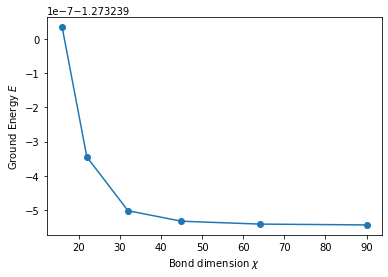

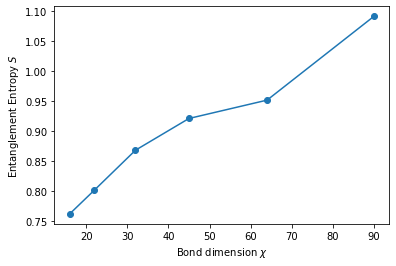

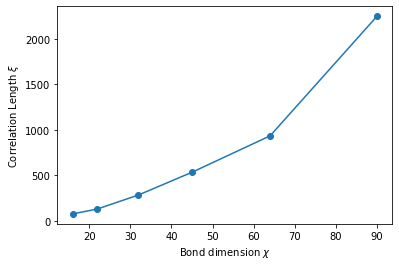

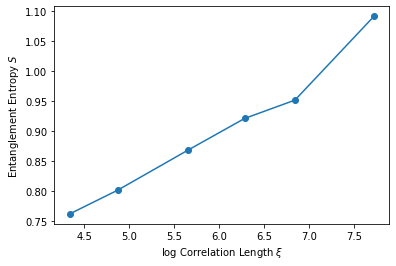

In [7]:
plot_results(data)

In [14]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

print(fitParams)

[0.44978893 0.43784362]


In [9]:
def run_TFI(calc_correlation=True):

    model_params = dict(
        L=2, 
        J=1., 
        g=1., 
        bc_MPS='infinite', 
        conserve='best',
        verbose=0,
        )
    prod_state = ["up"] * model_params['L']
    M = TFIChain(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-8,
        'max_sweeps': 1000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [10]:
data2=run_TFI()



==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-08 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732294404668103, S = nan, norm_err = 9.1e-04
Current memory usage 164.1 MB, time elapsed: 5.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2977e-10, max_E_trunc = 2.0405e-09
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2732370232930705, S = nan, norm_err = 5.4e-04
Current memory usage 164.1 MB, time elapsed: 9.9 s
Delta E = -7.5828e-07, Delta S = 0.0000e+00 (per sweep)

Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732389659634578, S = 0.7625091806443471, norm_err = 1.8e-05
Current memory usage 164.1 MB, time elapsed: 45.6 s
Delta E = 7.3214e-12, Delta S = 5.6103e-06 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1065e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732389659751107, S = 0.7626773690686126, norm_err = 1.0e-05
Current memory usage 164.1 MB, time elapsed: 47.1 s
Delta E = -1.1653e-12, Delta S = 1.6819e-05 (per sweep)
max_trunc_err = 3.3830e-08, max_E_trunc = 2.1094e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.2732389658900161, S = 0.7626696668536169, norm_err = 1.0e-05
Current memory usage 164.1 MB, time elapsed: 48.6 s
Delta E = 8.5095e-12, Delta S = -7.7022e-07 (per sweep)
max_trunc_err = 3.3903e-08, max_E_trunc = 2.1139e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 240, age = 2960
Energy = -1.2

Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732389654536291, S = 0.7630674797267314, norm_err = 1.4e-05
Current memory usage 164.1 MB, time elapsed: 78.3 s
Delta E = -6.4915e-12, Delta S = 2.0716e-05 (per sweep)
max_trunc_err = 3.4066e-08, max_E_trunc = 2.1241e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732389653168639, S = 0.7628497178436571, norm_err = 5.8e-06
Current memory usage 164.1 MB, time elapsed: 79.8 s
Delta E = 1.3677e-11, Delta S = -2.1776e-05 (per sweep)
max_trunc_err = 3.4148e-08, max_E_trunc = 2.1290e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.2732389653862128, S = 0.7630772049301662, norm_err = 1.5e-05
Current memory usage 164.1 MB, time elapsed: 81.3 s
Delta E = -6.9349e-12, Delta S = 2.2749e-05 (per sweep)
max_trunc_err = 3.4067e-08, max_E_trunc = 2.1242e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 450, age = 5480
Energy = -1.

Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732389649090692, S = 0.7637656869654773, norm_err = 4.7e-05
Current memory usage 164.1 MB, time elapsed: 125.9 s
Delta E = -3.5266e-11, Delta S = -1.5689e-05 (per sweep)
max_trunc_err = 3.4130e-08, max_E_trunc = 2.1260e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 640, age = 7760
Energy = -1.2732389652012444, S = 0.7635869761702239, norm_err = 4.0e-05
Current memory usage 164.1 MB, time elapsed: 127.4 s
Delta E = -2.9218e-11, Delta S = -1.7871e-05 (per sweep)
max_trunc_err = 3.4105e-08, max_E_trunc = 2.1251e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 650, age = 7880
Energy = -1.2732389654438521, S = 0.7634632102529857, norm_err = 3.0e-05
Current memory usage 164.1 MB, time elapsed: 128.9 s
Delta E = -2.4261e-11, Delta S = -1.2377e-05 (per sweep)
max_trunc_err = 3.4074e-08, max_E_trunc = 2.1239e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 660, age = 8000
Energy

Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732389657139720, S = 0.7629466382014540, norm_err = 5.8e-06
Current memory usage 164.1 MB, time elapsed: 157.8 s
Delta E = 2.9786e-12, Delta S = -4.9600e-06 (per sweep)
max_trunc_err = 3.4095e-08, max_E_trunc = 2.1259e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 850, age = 10280
Energy = -1.2732389657394378, S = 0.7629987752777219, norm_err = 8.4e-06
Current memory usage 164.1 MB, time elapsed: 159.2 s
Delta E = -2.5466e-12, Delta S = 5.2137e-06 (per sweep)
max_trunc_err = 3.4078e-08, max_E_trunc = 2.1249e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 860, age = 10400
Energy = -1.2732389657073782, S = 0.7629436458312754, norm_err = 5.7e-06
Current memory usage 164.1 MB, time elapsed: 160.6 s
Delta E = 3.2060e-12, Delta S = -5.5129e-06 (per sweep)
max_trunc_err = 3.4097e-08, max_E_trunc = 2.1259e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 870, age = 10520
Energ

disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 440
Energy = -1.2732392278783635, S = 0.7681182586310779, norm_err = 2.2e-04
Current memory usage 164.1 MB, time elapsed: 13.0 s
Delta E = -7.2888e-09, Delta S = nan (per sweep)
max_trunc_err = 1.8817e-08, max_E_trunc = 6.3011e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 40, age = 560
Energy = -1.2732392776958221, S = 0.7739707069763749, norm_err = 6.9e-05
Current memory usage 164.1 MB, time elapsed: 16.0 s
Delta E = -4.9817e-09, Delta S = 5.8524e-04 (per sweep)
max_trunc_err = 8.9905e-09, max_E_trunc = 6.0562e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 50, age = 680
Energy = -1.2732393141058509, S = 0.7799546143098386, norm_err = 1.0e-04
Current memory usage 164.1 MB, time elapsed: 19.1 s
Delta E = -3.6410e-09, Delta S = 5.9839e-04 (per sweep)
max_trunc_err = 8.8745e-09, max_E_trunc = 6.0153e-08
MPS bond dimensions: [22, 22]
Updating environme

Updating environment
.....
sweep 240, age = 2960
Energy = -1.2732393446499373, S = 0.8014645710197967, norm_err = 1.1e-05
Current memory usage 164.1 MB, time elapsed: 65.1 s
Delta E = 4.3258e-12, Delta S = 6.6447e-05 (per sweep)
max_trunc_err = 1.1316e-08, max_E_trunc = 7.6605e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 250, age = 3080
Energy = -1.2732393167439113, S = 0.8014884393848335, norm_err = 6.0e-05
Current memory usage 164.1 MB, time elapsed: 68.1 s
Delta E = 2.7906e-09, Delta S = 2.3868e-06 (per sweep)
max_trunc_err = 1.1545e-08, max_E_trunc = 7.7876e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 260, age = 3200
Energy = -1.2732393440913938, S = 0.8013469106443760, norm_err = 3.2e-05
Current memory usage 164.1 MB, time elapsed: 69.8 s
Delta E = -2.7347e-09, Delta S = -1.4153e-05 (per sweep)
max_trunc_err = 1.1360e-08, max_E_trunc = 7.6881e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 270, age = 3320
Energy = -1.2

Updating environment
.....
sweep 450, age = 5480
Energy = -1.2732393377918925, S = 0.8019378730614752, norm_err = 6.0e-05
Current memory usage 164.1 MB, time elapsed: 123.4 s
Delta E = -1.4241e-09, Delta S = 4.5100e-06 (per sweep)
max_trunc_err = 1.1636e-08, max_E_trunc = 7.8485e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 460, age = 5600
Energy = -1.2732393413562022, S = 0.8017753009134614, norm_err = 4.0e-05
Current memory usage 164.1 MB, time elapsed: 126.3 s
Delta E = -3.5643e-10, Delta S = -1.6257e-05 (per sweep)
max_trunc_err = 1.1637e-08, max_E_trunc = 7.8437e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 470, age = 5720
Energy = -1.2732393328930129, S = 0.8018771458356767, norm_err = 5.3e-05
Current memory usage 164.1 MB, time elapsed: 129.1 s
Delta E = 8.4632e-10, Delta S = 1.0184e-05 (per sweep)
max_trunc_err = 1.1609e-08, max_E_trunc = 7.8290e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 480, age = 5840
Energy = 

Updating environment
.....
sweep 660, age = 8000
Energy = -1.2732393416313244, S = 0.8021412659815582, norm_err = 5.5e-05
Current memory usage 164.1 MB, time elapsed: 183.4 s
Delta E = -2.0831e-09, Delta S = 1.5330e-05 (per sweep)
max_trunc_err = 1.1724e-08, max_E_trunc = 7.9030e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 670, age = 8120
Energy = -1.2732393434305322, S = 0.8021396627382539, norm_err = 3.3e-05
Current memory usage 164.1 MB, time elapsed: 185.8 s
Delta E = -1.7992e-10, Delta S = -1.6032e-07 (per sweep)
max_trunc_err = 1.1457e-08, max_E_trunc = 7.7511e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 680, age = 8240
Energy = -1.2732393444935042, S = 0.8022066275786597, norm_err = 8.3e-06
Current memory usage 164.1 MB, time elapsed: 187.9 s
Delta E = -1.0630e-10, Delta S = 6.6965e-06 (per sweep)
max_trunc_err = 1.1454e-08, max_E_trunc = 7.7496e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 690, age = 8360
Energy =

Updating environment
.....
sweep 870, age = 10520
Energy = -1.2732393372959905, S = 0.8017733898633455, norm_err = 3.8e-05
Current memory usage 164.1 MB, time elapsed: 243.1 s
Delta E = -1.1937e-09, Delta S = 1.3041e-05 (per sweep)
max_trunc_err = 1.1533e-08, max_E_trunc = 7.7804e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 880, age = 10640
Energy = -1.2732393359972320, S = 0.8017604488700518, norm_err = 5.4e-05
Current memory usage 164.1 MB, time elapsed: 246.1 s
Delta E = 1.2988e-10, Delta S = -1.2941e-06 (per sweep)
max_trunc_err = 1.1527e-08, max_E_trunc = 7.7767e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 890, age = 10760
Energy = -1.2732393433500420, S = 0.8028349209781197, norm_err = 6.4e-05
Current memory usage 164.1 MB, time elapsed: 247.9 s
Delta E = -7.3528e-10, Delta S = 1.0745e-04 (per sweep)
max_trunc_err = 1.1336e-08, max_E_trunc = 7.6745e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 900, age = 10880
Energ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
DMRG finished after 1000 sweeps.
total size = 12240, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999926262625+0j)
After the canonicalization:
Bond dim =  [22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732099606599014, S = nan, norm_err = 2.9e-02
Current memory usage 164.1 MB, time elapsed: 4.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1651e-09, max_E_trunc = 1.7752e-09
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2732386305243466, S = nan, norm_err = 4.7e-04
Current memory usage 164.1 MB, time elapsed: 9.8 s
D

Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732394977945205, S = 0.8481085906830862, norm_err = 3.6e-05
Current memory usage 164.1 MB, time elapsed: 43.2 s
Delta E = 4.0177e-11, Delta S = 1.8885e-04 (per sweep)
max_trunc_err = 1.8097e-09, max_E_trunc = 1.2248e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732394989106979, S = 0.8499128967412203, norm_err = 2.8e-05
Current memory usage 164.1 MB, time elapsed: 44.8 s
Delta E = -1.1162e-10, Delta S = 1.8043e-04 (per sweep)
max_trunc_err = 1.8419e-09, max_E_trunc = 1.2456e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732395003544070, S = 0.8515977441202325, norm_err = 3.5e-05
Current memory usage 164.1 MB, time elapsed: 45.7 s
Delta E = -1.4437e-10, Delta S = 1.6848e-04 (per sweep)
max_trunc_err = 1.8256e-09, max_E_trunc = 1.2378e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.2

Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395020467493, S = 0.8661596425909471, norm_err = 1.3e-05
Current memory usage 164.1 MB, time elapsed: 67.0 s
Delta E = -1.0850e-10, Delta S = 8.3177e-06 (per sweep)
max_trunc_err = 2.1770e-09, max_E_trunc = 1.4615e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732394985182509, S = 0.8663781489571276, norm_err = 2.0e-05
Current memory usage 164.1 MB, time elapsed: 68.4 s
Delta E = 3.5285e-10, Delta S = 2.1851e-05 (per sweep)
max_trunc_err = 2.2447e-09, max_E_trunc = 1.5015e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732395011521476, S = 0.8667656035160385, norm_err = 2.5e-05
Current memory usage 164.1 MB, time elapsed: 69.7 s
Delta E = -2.6339e-10, Delta S = 3.8745e-05 (per sweep)
max_trunc_err = 2.2465e-09, max_E_trunc = 1.5017e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/np_conserved.py:4480: UserWarning: SVD with lapack_driver 'gesdd' failed. Use backup 'gesvd'
  U_b, S_b, VH_b = svd_flat(block, full_matrices, True, overwrite_a, check_finite=True)


Updating environment
.....
sweep 550, age = 6680
Energy = -1.2732395007558353, S = 0.8688830497163158, norm_err = 2.5e-05
Current memory usage 164.1 MB, time elapsed: 84.1 s
Delta E = 6.9940e-11, Delta S = -5.1909e-05 (per sweep)
max_trunc_err = 2.3338e-09, max_E_trunc = 1.5587e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 560, age = 6800
Energy = -1.2732394991699039, S = 0.8697860843239895, norm_err = 2.8e-05
Current memory usage 164.1 MB, time elapsed: 85.3 s
Delta E = 1.5859e-10, Delta S = 9.0303e-05 (per sweep)
max_trunc_err = 2.3300e-09, max_E_trunc = 1.5552e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 570, age = 6920
Energy = -1.2732395016280407, S = 0.8697294289966317, norm_err = 1.4e-05
Current memory usage 164.1 MB, time elapsed: 86.4 s
Delta E = -2.4581e-10, Delta S = -5.6655e-06 (per sweep)
max_trunc_err = 2.3420e-09, max_E_trunc = 1.5643e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 580, age = 7040
Energy = -1.

Updating environment
.....
sweep 760, age = 9200
Energy = -1.2732395015123075, S = 0.8700958117932869, norm_err = 2.1e-05
Current memory usage 164.1 MB, time elapsed: 109.1 s
Delta E = -7.9058e-11, Delta S = -5.6685e-06 (per sweep)
max_trunc_err = 2.3720e-09, max_E_trunc = 1.5811e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 770, age = 9320
Energy = -1.2732395018445004, S = 0.8698353136307441, norm_err = 2.1e-05
Current memory usage 164.1 MB, time elapsed: 110.0 s
Delta E = -3.3219e-11, Delta S = -2.6050e-05 (per sweep)
max_trunc_err = 2.3112e-09, max_E_trunc = 1.5458e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 780, age = 9440
Energy = -1.2732394979784658, S = 0.8705206460735710, norm_err = 2.2e-05
Current memory usage 164.1 MB, time elapsed: 111.2 s
Delta E = 3.8660e-10, Delta S = 6.8533e-05 (per sweep)
max_trunc_err = 2.3654e-09, max_E_trunc = 1.5776e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 790, age = 9560
Energy =

Updating environment
.....
sweep 970, age = 11720
Energy = -1.2732395021280354, S = 0.8712936975715417, norm_err = 2.3e-05
Current memory usage 164.1 MB, time elapsed: 159.7 s
Delta E = 4.7976e-12, Delta S = 8.9664e-05 (per sweep)
max_trunc_err = 2.3082e-09, max_E_trunc = 1.5454e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 980, age = 11840
Energy = -1.2732395020266267, S = 0.8700795204051487, norm_err = 3.6e-05
Current memory usage 164.1 MB, time elapsed: 161.3 s
Delta E = 1.0141e-11, Delta S = -1.2142e-04 (per sweep)
max_trunc_err = 2.3094e-09, max_E_trunc = 1.5461e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 990, age = 11960
Energy = -1.2732395018217630, S = 0.8717246981429463, norm_err = 5.2e-05
Current memory usage 164.1 MB, time elapsed: 162.8 s
Delta E = 2.0486e-11, Delta S = 1.6452e-04 (per sweep)
max_trunc_err = 2.3061e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 1000, age = 12080
Energy

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.72e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000078+0j)
After the canonicalization:
Bond dim =  [32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  45 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732378056921050, S = nan, norm_err = 5.6e-04
Current memory usage 164.1 MB, time elapsed: 5.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2757e-11, max_E_trunc = 2.7228e-11
MPS bond dimensio

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732395183759309, S = 0.8482500857961264, norm_err = 5.7e-05
Current memory usage 164.1 MB, time elapsed: 62.3 s
Delta E = -1.8598e-10, Delta S = 3.7939e-04 (per sweep)
max_trunc_err = 2.1340e-10, max_E_trunc = 1.3183e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732395203897227, S = 0.8517866071773965, norm_err = 5.1e-05
Current memory usage 164.1 MB, time elapsed: 65.0 s
Delta E = -2.0138e-10, Delta S = 3.5365e-04 (per sweep)
max_trunc_err = 2.2703e-10, max_E_trunc = 1.3983e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395219056798, S = 0.8550499996987677, norm_err = 4.6e-05
Current memory usage 164.1 MB, time elapsed: 67.4 s
Delta E = -1.5160e-10, Delta S = 3.2634e-04 (per sweep)
max_trunc_err = 2.3881e-10, max_E_trunc = 1.4775e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395310142692, S = 0.8937135117495143, norm_err = 2.1e-05
Current memory usage 164.1 MB, time elapsed: 99.0 s
Delta E = -4.0848e-11, Delta S = 8.6441e-05 (per sweep)
max_trunc_err = 4.6359e-10, max_E_trunc = 2.8358e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395313635152, S = 0.8951506129256814, norm_err = 2.7e-05
Current memory usage 164.1 MB, time elapsed: 100.2 s
Delta E = -3.4925e-11, Delta S = 1.4371e-04 (per sweep)
max_trunc_err = 4.7379e-10, max_E_trunc = 2.8949e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395315730400, S = 0.8958973518406661, norm_err = 1.6e-05
Current memory usage 164.1 MB, time elapsed: 101.4 s
Delta E = -2.0952e-11, Delta S = 7.4674e-05 (per sweep)
max_trunc_err = 4.8169e-10, max_E_trunc = 2.9404e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 430, age = 5240
Energy = -

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395327163886, S = 0.9110198817357742, norm_err = 1.1e-05
Current memory usage 164.1 MB, time elapsed: 125.9 s
Delta E = -6.9963e-11, Delta S = 5.1012e-06 (per sweep)
max_trunc_err = 5.2984e-10, max_E_trunc = 3.4142e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395330904183, S = 0.9116396335823382, norm_err = 3.5e-06
Current memory usage 164.1 MB, time elapsed: 126.8 s
Delta E = -3.7403e-11, Delta S = 6.1975e-05 (per sweep)
max_trunc_err = 5.2070e-10, max_E_trunc = 3.3597e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395330781401, S = 0.9131387335009656, norm_err = 1.5e-05
Current memory usage 164.1 MB, time elapsed: 127.5 s
Delta E = 1.2278e-12, Delta S = 1.4991e-04 (per sweep)
max_trunc_err = 5.2907e-10, max_E_trunc = 3.4015e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 640, age = 7760
Energy = -

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395333180193, S = 0.9190882917057435, norm_err = 1.2e-05
Current memory usage 164.1 MB, time elapsed: 145.6 s
Delta E = -7.8876e-11, Delta S = -2.1258e-05 (per sweep)
max_trunc_err = 5.6705e-10, max_E_trunc = 3.6380e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395333025579, S = 0.9198441764771896, norm_err = 5.6e-06
Current memory usage 164.1 MB, time elapsed: 146.3 s
Delta E = 1.5461e-12, Delta S = 7.5588e-05 (per sweep)
max_trunc_err = 5.6904e-10, max_E_trunc = 3.6507e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395332809574, S = 0.9192378143291937, norm_err = 1.4e-05
Current memory usage 164.1 MB, time elapsed: 147.0 s
Delta E = 2.1600e-12, Delta S = -6.0636e-05 (per sweep)
max_trunc_err = 5.6951e-10, max_E_trunc = 3.6598e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 850, age = 10280
Energy

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.40e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999962+0j)
After the canonicalization:
Bond dim =  [45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732374101735040, S = nan, norm_err = 5.7e-04
Current memory usage 164.1 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0338e-12, max_E_trunc = -2.2453e-12
MPS bond dimensions: [64, 64]
Updating env

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732395213499785, S = 0.8494583464164434, norm_err = 6.1e-05
Current memory usage 164.1 MB, time elapsed: 36.6 s
Delta E = -2.4104e-10, Delta S = 4.2361e-04 (per sweep)
max_trunc_err = 1.7669e-11, max_E_trunc = 1.1914e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732395234449996, S = 0.8534494146567958, norm_err = 5.9e-05
Current memory usage 164.1 MB, time elapsed: 38.6 s
Delta E = -2.0950e-10, Delta S = 3.9911e-04 (per sweep)
max_trunc_err = 1.9214e-11, max_E_trunc = 1.3097e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395252480160, S = 0.8572278075661619, norm_err = 5.5e-05
Current memory usage 164.1 MB, time elapsed: 40.5 s
Delta E = -1.8030e-10, Delta S = 3.7784e-04 (per sweep)
max_trunc_err = 2.1044e-11, max_E_trunc = 1.4688e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395380493244, S = 0.9059031710980276, norm_err = 2.2e-05
Current memory usage 164.1 MB, time elapsed: 78.8 s
Delta E = -3.9859e-11, Delta S = 1.7303e-04 (per sweep)
max_trunc_err = 5.7556e-11, max_E_trunc = 3.9472e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395382618051, S = 0.9078478498978673, norm_err = 3.3e-05
Current memory usage 164.1 MB, time elapsed: 80.8 s
Delta E = -2.1248e-11, Delta S = 1.9447e-04 (per sweep)
max_trunc_err = 5.9512e-11, max_E_trunc = 4.0836e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395385199879, S = 0.9093502793967509, norm_err = 2.6e-05
Current memory usage 164.1 MB, time elapsed: 82.2 s
Delta E = -2.5818e-11, Delta S = 1.5024e-04 (per sweep)
max_trunc_err = 5.9768e-11, max_E_trunc = 4.0473e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395403829742, S = 0.9339941246164568, norm_err = 6.8e-06
Current memory usage 164.1 MB, time elapsed: 115.4 s
Delta E = 9.1859e-12, Delta S = 3.3876e-05 (per sweep)
max_trunc_err = 9.2624e-11, max_E_trunc = 6.2755e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395404539147, S = 0.9366485738030716, norm_err = 5.8e-05
Current memory usage 164.1 MB, time elapsed: 117.3 s
Delta E = -7.0941e-12, Delta S = 2.6544e-04 (per sweep)
max_trunc_err = 9.2466e-11, max_E_trunc = 6.2755e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395405178067, S = 0.9357477438289236, norm_err = 2.6e-05
Current memory usage 164.1 MB, time elapsed: 119.5 s
Delta E = -6.3892e-12, Delta S = -9.0083e-05 (per sweep)
max_trunc_err = 9.5529e-11, max_E_trunc = 6.4756e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 640, age = 7760
Energy = 

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395409116180, S = 0.9504355611582355, norm_err = 8.0e-06
Current memory usage 164.1 MB, time elapsed: 149.4 s
Delta E = -2.1009e-11, Delta S = -5.1132e-05 (per sweep)
max_trunc_err = 1.1767e-10, max_E_trunc = 7.9490e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395411123889, S = 0.9520573664333007, norm_err = 4.4e-05
Current memory usage 164.1 MB, time elapsed: 151.3 s
Delta E = -2.0077e-11, Delta S = 1.6218e-04 (per sweep)
max_trunc_err = 1.1905e-10, max_E_trunc = 7.8580e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395408036155, S = 0.9520893797915588, norm_err = 2.7e-05
Current memory usage 164.1 MB, time elapsed: 153.3 s
Delta E = 3.0877e-11, Delta S = 3.2013e-06 (per sweep)
max_trunc_err = 1.2004e-10, max_E_trunc = 8.0036e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 850, age = 10280
Energy

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.02e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+0j)
After the canonicalization:
Bond dim =  [64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  90 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732369820216860, S = nan, norm_err = 7.8e-04
Current memory usage 164.1 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4739e-12, max_E_trunc = -1.2534e-11
MPS bond dimensions: [90, 90]
Updating env

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732394905871729, S = 0.8135144035833988, norm_err = 1.0e-04
Current memory usage 164.1 MB, time elapsed: 48.1 s
Delta E = -9.4039e-10, Delta S = 6.7887e-04 (per sweep)
max_trunc_err = 3.5958e-13, max_E_trunc = 6.3665e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732394980466779, S = 0.8197659940533089, norm_err = 9.3e-05
Current memory usage 164.1 MB, time elapsed: 49.9 s
Delta E = -7.4595e-10, Delta S = 6.2516e-04 (per sweep)
max_trunc_err = 4.5067e-13, max_E_trunc = 5.4570e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395040616780, S = 0.8255799308058238, norm_err = 8.7e-05
Current memory usage 164.1 MB, time elapsed: 51.4 s
Delta E = -6.0150e-10, Delta S = 5.8139e-04 (per sweep)
max_trunc_err = 5.4913e-13, max_E_trunc = 5.9117e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395365974298, S = 0.8932564413148099, norm_err = 1.0e-05
Current memory usage 164.1 MB, time elapsed: 86.9 s
Delta E = -4.0529e-11, Delta S = 1.8761e-04 (per sweep)
max_trunc_err = 4.1805e-12, max_E_trunc = 3.3651e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395371371013, S = 0.8961549622612339, norm_err = 3.6e-05
Current memory usage 164.1 MB, time elapsed: 89.7 s
Delta E = -5.3967e-11, Delta S = 2.8985e-04 (per sweep)
max_trunc_err = 4.3847e-12, max_E_trunc = 3.0923e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395375435317, S = 0.8985071740604942, norm_err = 3.5e-05
Current memory usage 164.1 MB, time elapsed: 91.5 s
Delta E = -4.0643e-11, Delta S = 2.3522e-04 (per sweep)
max_trunc_err = 4.6254e-12, max_E_trunc = 3.8199e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395414736857, S = 0.9325429394469280, norm_err = 1.9e-05
Current memory usage 164.1 MB, time elapsed: 135.8 s
Delta E = -1.1164e-11, Delta S = 1.2280e-04 (per sweep)
max_trunc_err = 9.7887e-12, max_E_trunc = 8.3674e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395415439441, S = 0.9339077447644251, norm_err = 6.9e-06
Current memory usage 164.1 MB, time elapsed: 139.1 s
Delta E = -7.0258e-12, Delta S = 1.3648e-04 (per sweep)
max_trunc_err = 1.0302e-11, max_E_trunc = 8.1855e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395416594500, S = 0.9354334422503825, norm_err = 9.8e-06
Current memory usage 164.1 MB, time elapsed: 142.3 s
Delta E = -1.1551e-11, Delta S = 1.5257e-04 (per sweep)
max_trunc_err = 1.0599e-11, max_E_trunc = 7.8217e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 640, age = 7760
Energy = 

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395428160999, S = 0.9578387603674732, norm_err = 2.7e-05
Current memory usage 164.1 MB, time elapsed: 190.2 s
Delta E = -4.0700e-12, Delta S = 7.1015e-05 (per sweep)
max_trunc_err = 1.5000e-11, max_E_trunc = 1.0186e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395428583914, S = 0.9589771345189935, norm_err = 2.4e-05
Current memory usage 164.1 MB, time elapsed: 192.8 s
Delta E = -4.2292e-12, Delta S = 1.1384e-04 (per sweep)
max_trunc_err = 1.4980e-11, max_E_trunc = 1.1460e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395428597556, S = 0.9599554397793146, norm_err = 3.8e-05
Current memory usage 164.1 MB, time elapsed: 196.2 s
Delta E = -1.3642e-13, Delta S = 9.7831e-05 (per sweep)
max_trunc_err = 1.5582e-11, max_E_trunc = 1.1096e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 850, age = 10280
Energy

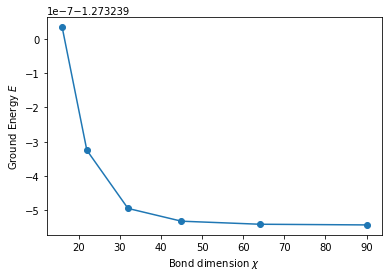

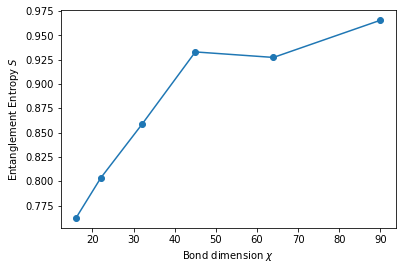

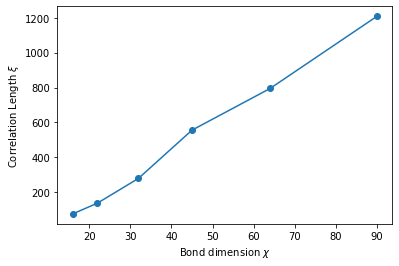

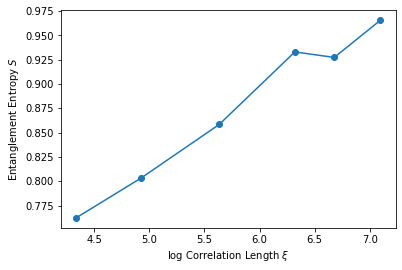

In [11]:
plot_results(data2)

In [ ]:
chi_list = data2['chi_list']
energy_list = data2['energy_list']
entropy_list = data2['entropy_list']
correlation_list = data2['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

print(fitParams)